In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("muted")

In [156]:
import psycopg
import json
config = (
        "user=nguu0123 password=nguu0123456 host=172.17.0.2 port=5432 dbname=nguu0123"
    )
connection = psycopg.connect(config, autocommit=True)
cursor = connection.cursor()
cursor.execute(""" 
select predictionquality.value -> 'QoA' as QoA, predict.requestid, model.name as model,
dataqualityreport.value as dataquality
from predictionquality 
inner join wasgeneratedby on predictionquality.id = wasgeneratedby.entityid
inner join predict on predict.id = wasgeneratedby.activityid
inner join wasassociatedwith on predict.id = wasassociatedwith.activityid
inner join model on wasassociatedwith.agentid = model.id
inner join dataqualityreport on dataqualityreport.requestid = predict.requestid
UNION ALL 
select predictionquality.value -> 'QoA' as QoA, ensemblefunction.requestid, 'aggregated' as model,
dataqualityreport.value as dataquality
from predictionquality 
inner join wasgeneratedby on predictionquality.id = wasgeneratedby.entityid
inner join ensemblefunction on ensemblefunction.id = wasgeneratedby.activityid
inner join dataqualityreport on dataqualityreport.requestid = ensemblefunction.requestid
""")
data = cursor.fetchall()

In [157]:
path = '/home/nguu0123/git/thesis/ray_deployment/logs/'
accuracy = pd.read_csv(path + 'mean_accuracy_with_prov_v5n_v8n.csv', names=["image id", "requestid","model", "correctly detect", "true class"], skiprows=50)
max_accuracy = pd.read_csv(path + 'max_accuracy_with_prov_v5n_v8n.csv', names=["image id", "requestid","model", "correctly detect", "true class"], skiprows=50)
accuracy

,image id,requestid,model,correctly detect,true class
0,5708252159_5b4ac86a01_z.jpg,09fbc850-c573-4f56-97b7-e9b14bf2170a,yolov5n,1,bicycle
1,5708252159_5b4ac86a01_z.jpg,09fbc850-c573-4f56-97b7-e9b14bf2170a,yolov8n,1,bicycle
2,2667833832_bf9ddddac5_z.jpg,c5f0c806-bf57-4bd9-83ea-e99eed665112,aggregated,1,cat
3,2667833832_bf9ddddac5_z.jpg,c5f0c806-bf57-4bd9-83ea-e99eed665112,yolov5n,0,cat
4,2667833832_bf9ddddac5_z.jpg,c5f0c806-bf57-4bd9-83ea-e99eed665112,yolov8n,1,cat
...,...,...,...,...,...
1746,2522213440_edbcb5ba05_z_degraded.jpg,5c936bcf-0806-4939-85fb-ce20bd9db31a,yolov5n,1,person
1747,2522213440_edbcb5ba05_z_degraded.jpg,5c936bcf-0806-4939-85fb-ce20bd9db31a,yolov8n,1,person
1748,6431153899_9ac59a36b4_z_degraded.jpg,dba66811-cc50-4500-851a-ac456dd685ab,aggregated,1,car
1749,6431153899_9ac59a36b4_z_degraded.jpg,dba66811-cc50-4500-851a-ac456dd685ab,yolov5n,0,car


In [158]:
test = list(map(lambda x: [x[0]["object detected"], x[1], x[2], x[3]["resolution"], x[3]["contrast"], x[3]["sharpness"], x[3]["brightness"], x[3]["saturation"], x[3]["noise"], x[3]["blur"]], data))
prov = pd.DataFrame(test, columns=["object detected", "requestid", "model", "resolution", "contrast", "sharpness", "brightness", "saturation", "noise", "blur"])

In [159]:
prov["model"] = prov["model"].transform(lambda x: "yolov5n" if x == 'Yolo5Inference' else "yolov8n" if x == 'Yolo8Inference' else x)

In [160]:
df = pd.merge(prov, accuracy, on=['requestid','model'])
dfmax = pd.merge(prov, max_accuracy, on =['requestid', 'model'])
#df.to_csv("ensemble_analysis_with_v5n_v8n.csv")

In [161]:
def get_average(data, windows):
    return data.rolling(windows).mean().tolist()[windows - 1:]
def get_p99(data, windows):
    return data.rolling(windows).quantile(0.99).tolist()[windows - 1:]

In [162]:
df

,object detected,requestid,model,resolution,contrast,sharpness,brightness,saturation,noise,blur,image id,correctly detect,true class
0,"[[bicycle, 0.702454686164856], [bicycle, 0.481...",09fbc850-c573-4f56-97b7-e9b14bf2170a,yolov5n,"[640, 480]",1033.62,1033.62,108.82,70.20,2.648112,1033.618504,5708252159_5b4ac86a01_z.jpg,1,bicycle
1,"[[bicycle, 0.9165442585945129], [bicycle, 0.90...",09fbc850-c573-4f56-97b7-e9b14bf2170a,yolov8n,"[640, 480]",1033.62,1033.62,108.82,70.20,2.648112,1033.618504,5708252159_5b4ac86a01_z.jpg,1,bicycle
2,"[[potted plant, 0.5745967030525208]]",c5f0c806-bf57-4bd9-83ea-e99eed665112,yolov5n,"[480, 640]",1364.77,1364.77,117.43,59.84,7.627604,1364.774320,2667833832_bf9ddddac5_z.jpg,0,cat
3,"[[cat, 0.9075150489807129], [potted plant, 0.7...",c5f0c806-bf57-4bd9-83ea-e99eed665112,yolov8n,"[480, 640]",1364.77,1364.77,117.43,59.84,7.627604,1364.774320,2667833832_bf9ddddac5_z.jpg,1,cat
4,"[[clock, 0.3048875033855438]]",45213f1c-eabe-4fb1-86c3-dd32b8ef5f2d,yolov5n,"[640, 640]",807.04,807.04,49.65,65.22,61.290527,807.041931,15038212434_9e0e575008_z.jpg,0,car
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,"[[person, 0.7163987159729004], [person, 0.6400...",3e33b956-2f98-4fa9-812e-8c4158b03e99,aggregated,"[640, 480]",860.25,860.25,150.25,88.43,23.788737,860.249413,528252616_a57e6257ff_z_degraded.jpg,1,person
1747,"[[dog, 0.34669917821884155]]",381f53df-8f28-489e-8cea-1a81e06cb059,aggregated,"[639, 313]",5209.96,5209.96,143.04,77.72,34.119306,5209.964998,387284206_360c4e3d6e_z_degraded.jpg,1,dog
1748,"[[cat, 0.33336693048477173]]",f3863be8-bfd2-465e-877a-d7adfc7d2dcd,aggregated,"[640, 480]",106.28,106.28,139.33,94.24,48.416992,106.277363,17594682014_fcd2ac5ca3_z_degraded.jpg,1,cat
1749,"[[person, 0.891654908657074], [tie, 0.65607205...",5c936bcf-0806-4939-85fb-ce20bd9db31a,aggregated,"[639, 428]",1384.91,1384.91,200.79,30.10,58.081041,1384.912078,2522213440_edbcb5ba05_z_degraded.jpg,1,person


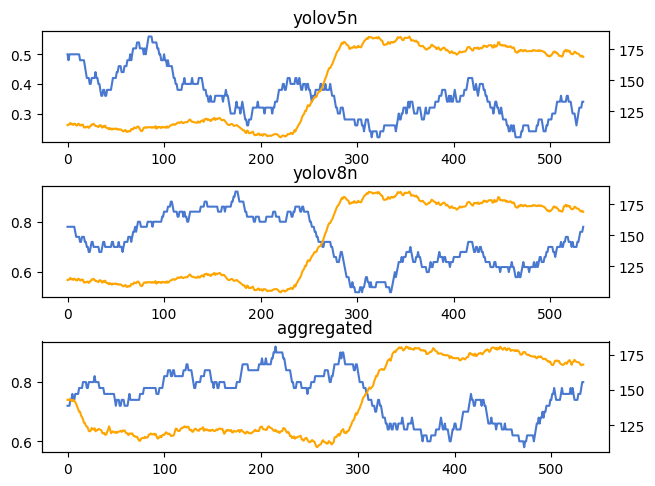

In [163]:
fig, ax1 = plt.subplots(3,1)
i = 0
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
for model in df["model"].unique():
    data = get_average(df[df["model"] == model]["correctly detect"],50)
    dataquality = get_average(df[df["model"] == model]["brightness"],50)
    sns_plot = sns.lineplot(y=data, x=range(len(data)), ax=ax1[i])
    ax2 = ax1[i].twinx()
    sns_plot = sns.lineplot(y=dataquality, x=range(len(dataquality)),  color='orange', ax=ax2)
    ax1[i].set_title(model)
    i += 1

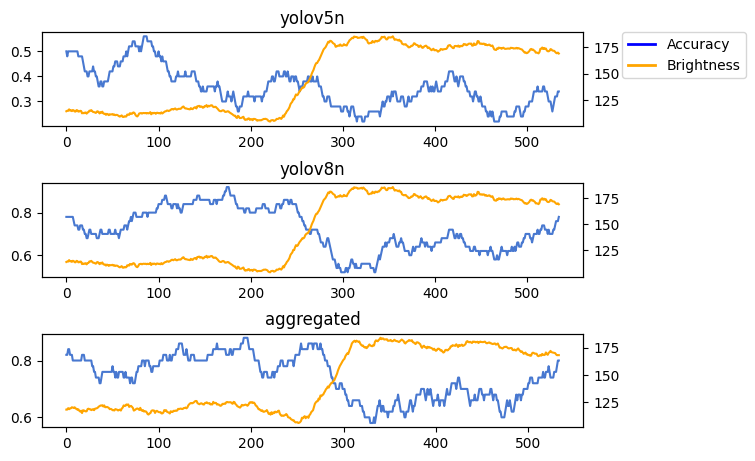

In [220]:
fig, ax1 = plt.subplots(3,1)
i = 0
fig.tight_layout(pad=2, w_pad=2, h_pad=2.0) # Or equivalently,  "plt.tight_layout()"
for model in dfmax["model"].unique():
    data = get_average(dfmax[dfmax["model"] == model]["correctly detect"],50)
    dataquality = get_average(dfmax[dfmax["model"] == model]["brightness"],50)
    sns_plot = sns.lineplot(y=data, x=range(len(data)), ax=ax1[i])
    ax2 = ax1[i].twinx()
    sns_plot = sns.lineplot(y=dataquality, x=range(len(dataquality)),  color='orange', ax=ax2)
    ax1[i].set_title(model)
    i += 1
line1 = plt.Line2D([0], [0], color='blue', lw=2)
line2 = plt.Line2D([0], [0], color='orange', lw=2)
handles = [line1, line2]
labels = ['Accuracy', 'Brightness']

# Add the legend outside the chart
ax1[0].legend(handles, labels, bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0.)
plt.show()
#fig.savefig("original_performance.pdf", bbox_inches='tight')

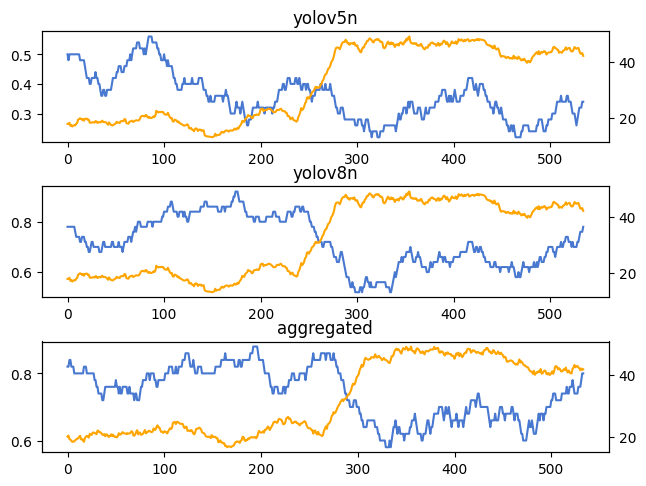

In [165]:
fig, ax1 = plt.subplots(3,1)
i = 0
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
for model in dfmax["model"].unique():
    data = get_average(dfmax[dfmax["model"] == model]["correctly detect"],50)
    dataquality = get_average(dfmax[dfmax["model"] == model]["noise"],50)
    sns_plot = sns.lineplot(y=data, x=range(len(data)), ax=ax1[i])
    ax2 = ax1[i].twinx()
    sns_plot = sns.lineplot(y=dataquality, x=range(len(dataquality)),  color='orange', ax=ax2)
    ax1[i].set_title(model)
    i += 1

In [166]:
df[df['image id'].transform(lambda x: 'degraded' in x)]

,object detected,requestid,model,resolution,contrast,sharpness,brightness,saturation,noise,blur,image id,correctly detect,true class
568,"[[boat, 0.46443799138069153]]",2bcb55fa-bfef-4419-b6de-fa5a7542185a,yolov5n,"[640, 480]",1075.93,1075.93,194.30,35.69,18.557617,1075.927002,5007439610_5bb351fc1f_z_degraded.jpg,0,car
569,"[[car, 0.6701564788818359]]",2bcb55fa-bfef-4419-b6de-fa5a7542185a,yolov8n,"[640, 480]",1075.93,1075.93,194.30,35.69,18.557617,1075.927002,5007439610_5bb351fc1f_z_degraded.jpg,1,car
570,"[[truck, 0.27034714818000793], [car, 0.2636929...",10aa9d32-d7ef-4cbf-8a89-31fbefb4571e,yolov5n,"[640, 640]",2557.87,2557.87,121.80,84.81,40.025635,2557.868204,16982913298_aa90f2a62b_z_degraded.jpg,1,car
571,"[[car, 0.5797562003135681], [car, 0.4932867884...",10aa9d32-d7ef-4cbf-8a89-31fbefb4571e,yolov8n,"[640, 640]",2557.87,2557.87,121.80,84.81,40.025635,2557.868204,16982913298_aa90f2a62b_z_degraded.jpg,1,car
572,"[[person, 0.6708159446716309], [bicycle, 0.395...",d5064167-cb04-4bd9-a44a-fc9d6200f0e6,yolov5n,"[640, 480]",6235.23,6235.23,184.46,33.16,34.580078,6235.233812,3353007655_56889b94a7_z_degraded.jpg,1,bicycle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,"[[person, 0.7163987159729004], [person, 0.6400...",3e33b956-2f98-4fa9-812e-8c4158b03e99,aggregated,"[640, 480]",860.25,860.25,150.25,88.43,23.788737,860.249413,528252616_a57e6257ff_z_degraded.jpg,1,person
1747,"[[dog, 0.34669917821884155]]",381f53df-8f28-489e-8cea-1a81e06cb059,aggregated,"[639, 313]",5209.96,5209.96,143.04,77.72,34.119306,5209.964998,387284206_360c4e3d6e_z_degraded.jpg,1,dog
1748,"[[cat, 0.33336693048477173]]",f3863be8-bfd2-465e-877a-d7adfc7d2dcd,aggregated,"[640, 480]",106.28,106.28,139.33,94.24,48.416992,106.277363,17594682014_fcd2ac5ca3_z_degraded.jpg,1,cat
1749,"[[person, 0.891654908657074], [tie, 0.65607205...",5c936bcf-0806-4939-85fb-ce20bd9db31a,aggregated,"[639, 428]",1384.91,1384.91,200.79,30.10,58.081041,1384.912078,2522213440_edbcb5ba05_z_degraded.jpg,1,person


In [167]:
# origin = df[df['image id'].transform(lambda x: 'degraded' not in x)]
# for model in origin["model"].unique():
#     print(model, '\n', origin[origin["model"] == model][["true class", "correctly detect"]].groupby("true class").mean(), '\n')

In [168]:
origin = dfmax[dfmax['image id'].transform(lambda x: 'degraded' not in x)]
for model in origin["model"].unique():
    print(model, '\n', origin[origin["model"] == model][["true class", "correctly detect"]].groupby("true class").mean(), '\n')

yolov5n 
             correctly detect
true class                  
bicycle             0.360000
car                 0.403846
cat                 0.136364
dog                 0.277778
person              0.887097 

yolov8n 
             correctly detect
true class                  
bicycle             0.660000
car                 0.692308
cat                 0.878788
dog                 0.740741
person              0.983871 

aggregated 
             correctly detect
true class                  
bicycle             0.714286
car                 0.730769
cat                 0.878788
dog                 0.777778
person              0.983871 



In [169]:
# degraded = df[df['image id'].transform(lambda x: 'degraded' in x)]
# for model in degraded["model"].unique():
#     print(model, '\n', degraded[degraded["model"] == model][["true class", "correctly detect"]].groupby("true class").mean(), '\n')

In [170]:
degraded = dfmax[dfmax['image id'].transform(lambda x: 'degraded' in x)]
for model in degraded["model"].unique():
    print(model, '\n', degraded[degraded["model"] == model][["true class", "correctly detect"]].groupby("true class").mean(), '\n')

yolov5n 
             correctly detect
true class                  
bicycle             0.383333
car                 0.258065
cat                 0.098592
dog                 0.080000
person              0.754386 

yolov8n 
             correctly detect
true class                  
bicycle             0.550000
car                 0.677419
cat                 0.591549
dog                 0.500000
person              0.929825 

aggregated 
             correctly detect
true class                  
bicycle             0.566667
car                 0.741935
cat                 0.591549
dog                 0.540000
person              0.929825 

